In [142]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/French.txt']
Slusarski


In [143]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

In [153]:
import torch.nn as nn
import torch.nn.functional as F
from ncps.torch import LTC

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        out_features = output_size
        in_features = input_size

        #from ncps.wirings import AutoNCP

        #wiring = AutoNCP(128, out_features)  # 16 units, 1 motor neuron

        #self.ltc = LTC(in_features, wiring, batch_first=True)
        self.emb=nn.Linear(input_size, 128)
        self.ltc=LTC(128, output_size)

        #self.i2h = nn.Linear(input_size, hidden_size)
        #self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        #output = self.h2o(hidden)
        input=self.emb(input)   
        output, hidden = self.ltc(input)
        output=self.h2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 19
rnn = RNN(n_letters, n_hidden, n_categories)

In [154]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
hidden.shape

torch.Size([1, 19])

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.6995, -2.7811, -3.0620, -2.9831, -2.7029, -3.2597, -3.0005, -2.4945,
         -3.2113, -2.6317, -2.8365, -2.9954, -2.9414, -3.1047, -3.0001, -3.0693,
         -2.8430, -2.7706]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 7)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Columbo
category = Arabic / line = Tuma
category = Dutch / line = Schuyler
category = Scottish / line = Hunter
category = Greek / line = Fotopoulos
category = Chinese / line = Guan
category = Chinese / line = Rong
category = Italian / line = De laurentis
category = Japanese / line = Nagata
category = Russian / line = Abdrashitov


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
'''
def train(category_tensor, line_tensor):
    hidden = torch.ones(1, n_hidden)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    #print(rnn.parameters())
    for p in rnn.parameters():  
        try:
            p.data.add_(p.grad.data, alpha=-learning_rate)
        except:
            pass

    return output, loss.item()
'''
learning_rate = 0.005

import torch.optim as optim

# Initialize the optimizer (SGD in this case, but you can use others like Adam)
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = torch.ones(1, n_hidden)

    # Zero gradients
    rnn.zero_grad()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Update parameters using the optimizer
    optimizer.step()

    return output, loss.item()


In [ ]:
import time
import math

n_iters = 100000
print_every = 500
plot_every = 500



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 8s) 3.1032 Guerra / Irish ✗ (Portuguese)
1000 1% (0m 16s) 3.0713 Luong / Arabic ✗ (Vietnamese)
1500 1% (0m 24s) 2.8482 Baumann / Irish ✗ (German)
2000 2% (0m 30s) 2.8096 Seaghdha / Korean ✗ (Irish)
2500 2% (0m 38s) 2.8741 Talanov / Spanish ✗ (Russian)
3000 3% (0m 46s) 2.7336 Macon / French ✓
3500 3% (0m 53s) 2.8636 Cardozo / Italian ✗ (Portuguese)
4000 4% (1m 1s) 2.9017 Fleischer / Italian ✗ (German)
4500 4% (1m 8s) 3.0285 Zimmermann / Irish ✗ (German)
5000 5% (1m 15s) 2.9013 Puig / Polish ✗ (Spanish)
5500 5% (1m 22s) 2.8750 Muso / Polish ✗ (Japanese)
6000 6% (1m 30s) 2.8339 Tessaro / Irish ✗ (Italian)
6500 6% (1m 39s) 2.9241 Castellano / Portuguese ✗ (Spanish)
7000 7% (1m 47s) 2.7127 O'Hara / Irish ✓
7500 7% (1m 55s) 2.8653 Southwick / Vietnamese ✗ (English)
8000 8% (2m 3s) 2.8498 Klimek / Vietnamese ✗ (Polish)
8500 8% (2m 12s) 2.8100 Lac / Korean ✗ (Vietnamese)
9000 9% (2m 19s) 2.8637 Walling / Korean ✗ (English)
9500 9% (2m 28s) 2.8863 Mckay / Irish ✗ (Scottish)
10000 10%

KeyboardInterrupt: 

In [ ]:
len(all_losses)
all_losses[-3]

2.1363757686056197

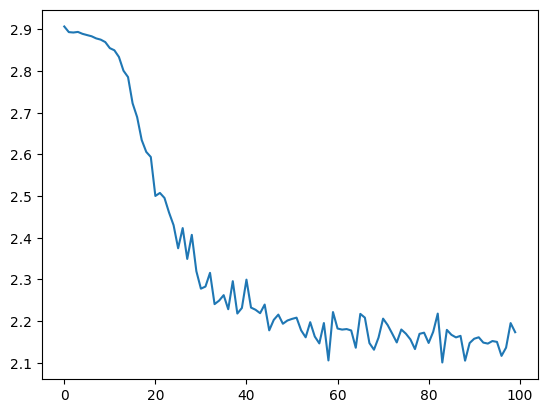

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_3554412/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3554412/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


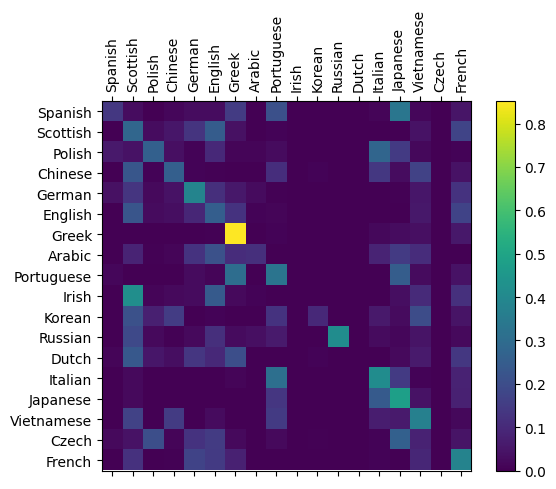

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Maria')
predict('Rasmus')
predict('Lembitu')


> Dovesky
(-1.48) English
(-1.48) Irish
(-1.78) Scottish

> Jackson
(-2.01) Scottish
(-2.06) Irish
(-2.06) Korean

> Satoshi
(-1.38) Italian
(-1.43) Polish
(-1.45) Japanese

> Maria
(-1.06) Japanese
(-1.83) Spanish
(-2.29) Portuguese

> Rasmus
(-0.74) Greek
(-1.95) Portuguese
(-2.57) Dutch

> Lembitu
(-1.35) Vietnamese
(-1.98) Chinese
(-2.18) Korean
